In [ ]:
import os
import math
import json
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import matplotlib.pyplot as plt


from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [ ]:
DATASET = "gsm8k"
DATASET_CONFIG = "main"
SAMPLE_N = 50
SELF_CONS_SAMPLES = 12
TEMPERATURE = 0.8
MAX_NEW_TOKENS = 128
ECE_BINS = 10
CALIBRATION_SPLIT = 0.3
SEED = 42

In [ ]:
PHI2_MODEL = "microsoft/phi-2"
LLAMA_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
QWEN_MODEL  = "Qwen/Qwen1.5-0.5B"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
random.seed(SEED)
np.random.seed(SEED)

Device: cuda


In [ ]:
def minmax_norm(arr):
    a = np.array(arr, dtype=float)
    mn, mx = a.min(), a.max()
    if np.isnan(mn) or np.isnan(mx):
        a = np.nan_to_num(a, nan=0.0)
        mn, mx = a.min(), a.max()
    if mx - mn < 1e-12:
        return np.zeros_like(a)
    return (a - mn) / (mx - mn)

In [ ]:
def token_entropy_from_logits(logits):
    if logits is None:
        return np.nan
    try:
        l = np.array(logits, dtype=float)
    except Exception:
        return np.nan
    maxes = l.max(axis=-1, keepdims=True)
    p = np.exp(l - maxes)
    p = p / (p.sum(axis=-1, keepdims=True) + 1e-12)
    ent = -np.sum(p * np.log(p + 1e-12), axis=-1)
    return float(np.nanmean(ent))

In [ ]:
from collections import Counter


def self_consistency_score(responses):
    if len(responses) == 0:
        return 0.0
    c = Counter(responses)
    most_common_count = c.most_common(1)[0][1]
    return most_common_count / len(responses)

In [ ]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_entropy_of_responses(responses, n_clusters=3):
    if len(responses) == 0:
        return 0.0
    if len(responses) == 1:
        return 0.0
    embeds = embed_model.encode(responses, convert_to_numpy=True)
    k = min(n_clusters, len(responses))
    if k <= 1:
        return 0.0
    km = KMeans(n_clusters=k, random_state=SEED).fit(embeds)
    labels = km.labels_
    counts = np.bincount(labels, minlength=k).astype(float)
    p = counts / counts.sum()
    ent = -np.sum(p * np.log(p + 1e-12))
    return float(ent)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import re

In [ ]:
print("Loading GSM8K...")
raw = load_dataset(DATASET, DATASET_CONFIG, split="train")
N = min(SAMPLE_N, len(raw))
raw = raw.select(range(N))
print(f"Using {N} samples from {DATASET}")

Loading GSM8K...


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Using 50 samples from gsm8k


In [ ]:
models = {}
def safe_load_model(name):
    try:
        tok = AutoTokenizer.from_pretrained(name, use_fast=False)
        mod = AutoModelForCausalLM.from_pretrained(name,torch_dtype=torch.float16,device_map='auto')
        mod.eval()
        return tok, mod
    except Exception as e:
        print(f"Failed to load {name}: {e}")
        return None, None


In [ ]:
phi_tokenizer, phi_model = safe_load_model(PHI2_MODEL)
if phi_model is not None:
    models['phi2'] = {'tokenizer': phi_tokenizer, 'model': phi_model}
else:
    print("phi model failed to load.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
llama_tokenizer, llama_model = safe_load_model(LLAMA_MODEL)
if llama_model is not None:
    models['llama'] = {'tokenizer': llama_tokenizer, 'model': llama_model}
else:
    print("model failed to load")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
qwen_tokenizer, qwen_model = safe_load_model(QWEN_MODEL)
if qwen_model is not None:
    models['qwen'] = {'tokenizer': qwen_tokenizer, 'model': qwen_model}
else:
    print("model failed to load. Replace LLAMA_MODEL with a valid HF repo id or use a smaller model.")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [ ]:
models

{'phi2': {'tokenizer': CodeGenTokenizer(name_or_path='microsoft/phi-2', vocab_size=50257, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
  	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
  	50257: AddedToken("                               ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
  	50258: AddedToken("                              ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
  	50259: AddedToken("                             ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
  	50260: AddedToken("                            ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
  	5

In [ ]:
def generate_with_model(tokenizer, model, prompt, num_samples=1, temperature=0.3, max_new_tokens=128, do_sample=True):
    outputs = []
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    input_len = inputs.input_ids.shape[1]
    for _ in range(num_samples):
        with torch.no_grad():
            out = model.generate(**inputs,
                                 max_new_tokens=max_new_tokens,
                                 do_sample=do_sample,
                                 temperature=temperature,
                                 return_dict_in_generate=True,
                                 output_scores=True)

        gen_ids = out.sequences[0][input_len:]
        text = tokenizer.decode(gen_ids, skip_special_tokens=True)
        scores = None
        try:
            scores = [s[0].detach().cpu().numpy() for s in out.scores]
            if len(scores) > 0:
                logits_np = np.stack(scores, axis=0)
            else:
                logits_np = None
        except Exception:
            logits_np = None
        outputs.append({'text': text, 'logits': logits_np})

    return outputs

In [ ]:
import re
def extract_number(s):
    if s is None:
        return None
    s = str(s)
    if '####' in s:
        tail = s.split('####')[-1]
    else:
        tail = s
    nums = re.findall(r"(-?\d+\.?\d*)", tail)
    if not nums:
        nums = re.findall(r"(-?\d+\.?\d*)", s)
        if not nums:
            return None
    try:
        return float(nums[-1])
    except:
        return None

In [ ]:
def extract_number_from_response(text):
    if text is None:
        return None
    text = str(text)
    numbers = re.findall(r'(-?\d+\.?\d*)', text)
    if not numbers:
        return None
    try:
        return float(numbers[-1])
    except:
        return None


In [ ]:
for model_key, md in models.items():
    results = []
    print(f"Running inference for {model_key} ...")
    tok = md['tokenizer']
    mod = md['model']
    for i, item in enumerate(tqdm(raw)):
        q = item['question']
        true_ans = item.get('answer', '').strip()
        prompt = prompt = q + "\n####\nPlease provide only the final numeric answer without explanation:"
        outs = generate_with_model(tok, mod, prompt, num_samples=SELF_CONS_SAMPLES, temperature=TEMPERATURE, max_new_tokens=MAX_NEW_TOKENS)
        responses = [o['text'].strip() for o in outs]
        sc = self_consistency_score(responses)
        sem_ent = semantic_entropy_of_responses(responses, n_clusters=3)
        token_ents = [token_entropy_from_logits(o['logits']) for o in outs]
        token_ent = float(np.nanmean([t for t in token_ents if not np.isnan(t)])) if any([not np.isnan(t) for t in token_ents]) else np.nan
        top_resp = responses[0] if len(responses) > 0 else ""


        true_num = extract_number(true_ans)
        resp_num = extract_number_from_response(top_resp)
        is_correct = 0
        if true_num is not None and resp_num is not None:
          if abs(true_num - resp_num) <= 1e-2 or (abs(true_num - resp_num) / max(abs(true_num), 1e-6)) < 1e-2:
            is_correct = 1
        else:
          if str(true_ans).strip() in top_resp:
            is_correct = 1


        results.append({
            'idx': i,
            'model': model_key,
            'question': q,
            'true_answer': true_ans,
            'response': top_resp,
            'self_consistency': sc,
            'semantic_entropy': sem_ent,
            'token_entropy': token_ent,
            'correct': is_correct
        })

    pd.DataFrame(results).to_csv(f"results_{model_key}.csv", index=False)

Running inference for phi2 ...


  0%|          | 0/50 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Running inference for llama ...


  0%|          | 0/50 [00:00<?, ?it/s]

Running inference for qwen ...


  0%|          | 0/50 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for

Processing model: qwen


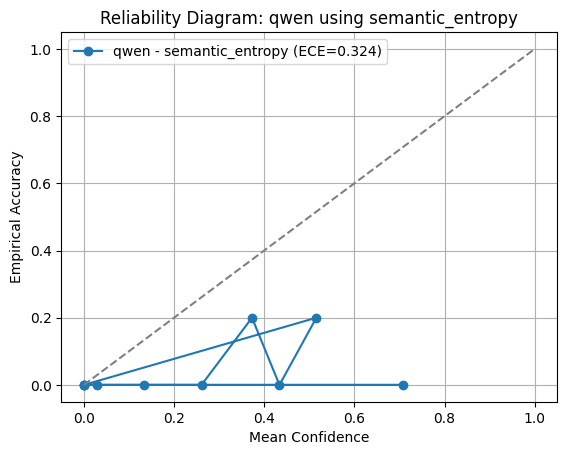

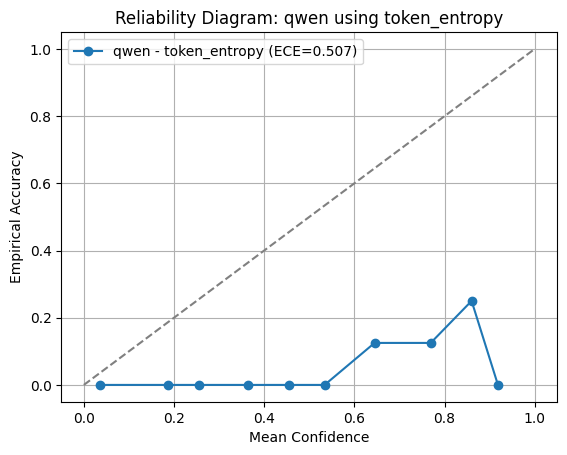

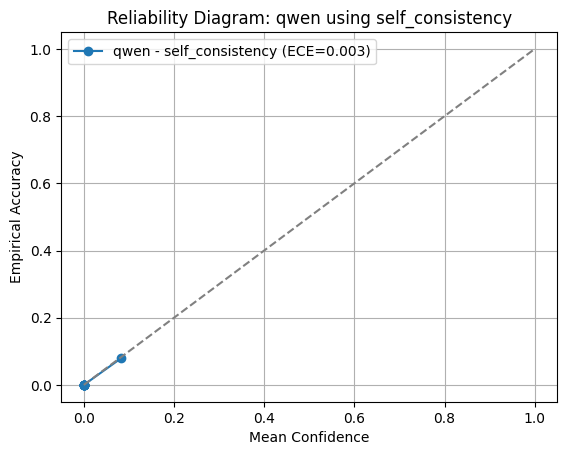

Processing model: phi2


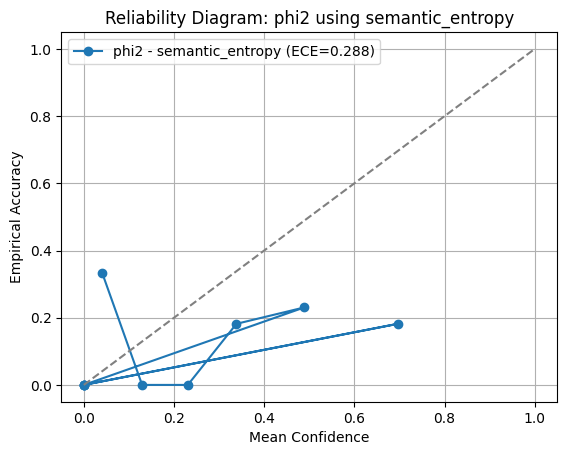

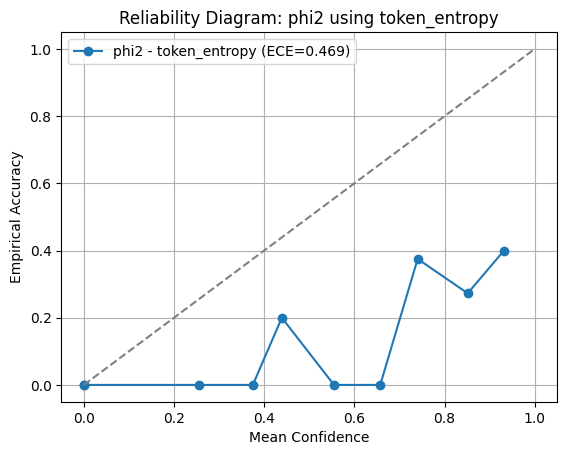

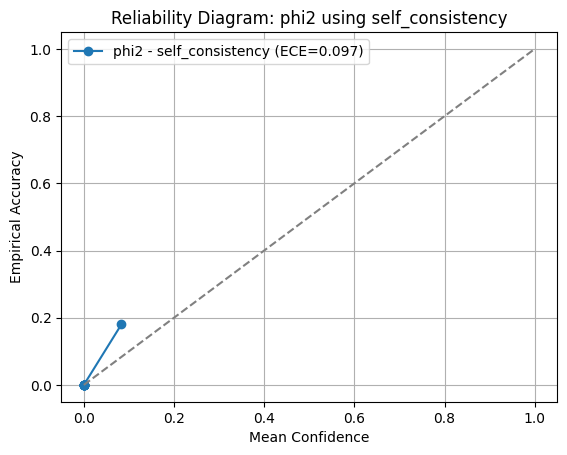

Processing model: llama


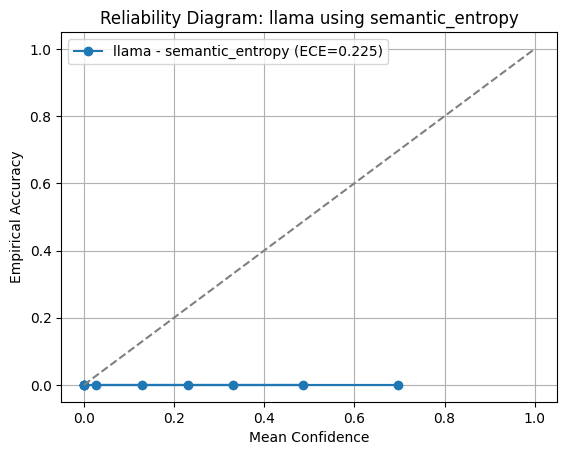

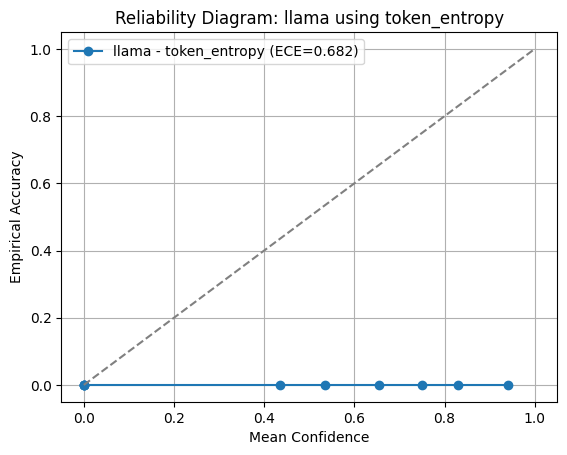

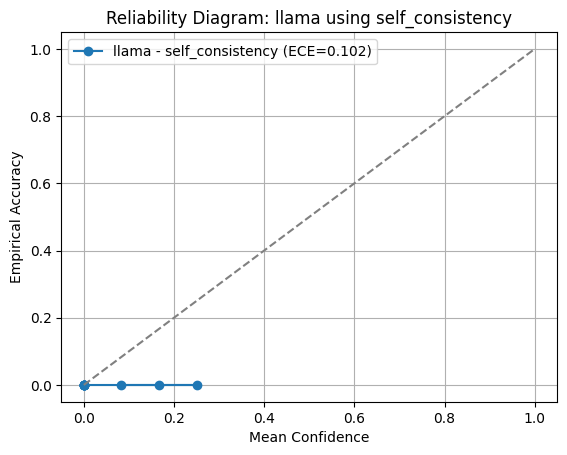

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def normalize_scores(x):
    return (x - x.min()) / (x.max() - x.min())

def compute_reliability_diagram(confidences, correct, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1
    accuracies = np.zeros(n_bins)
    confidences_bin = np.zeros(n_bins)
    counts = np.zeros(n_bins)
    for b in range(n_bins):
        in_bin = bin_ids == b
        if np.sum(in_bin) > 0:
            accuracies[b] = correct[in_bin].mean()
            confidences_bin[b] = confidences[in_bin].mean()
            counts[b] = np.sum(in_bin)
    total = np.sum(counts)
    ece = np.sum((counts / total) * np.abs(accuracies - confidences_bin))
    return confidences_bin, accuracies, ece

def plot_reliability_curve(confidences_bin, accuracies, model_name, unc_name, ece):
    plt.plot(confidences_bin, accuracies, marker='o', label=f'{model_name} - {unc_name} (ECE={ece:.3f})')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel('Mean Confidence')
    plt.ylabel('Empirical Accuracy')
    plt.title(f'Reliability Diagram: {model_name} using {unc_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def process_model_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    conf_semantic = 1 - normalize_scores(df['semantic_entropy'])
    conf_token = 1 - normalize_scores(df['token_entropy'])
    conf_self_cons = df['self_consistency']  # assumed already in [0,1]
    correct = df['correct']

    for conf, name in zip([conf_semantic, conf_token, conf_self_cons],
                          ['semantic_entropy', 'token_entropy', 'self_consistency']):
        conf_bin, acc_bin, ece = compute_reliability_diagram(conf.values, correct.values)
        plot_reliability_curve(conf_bin, acc_bin, model_name, name, ece)

files = {
    'qwen': 'results_qwen.csv',
    'phi2': 'results_phi2.csv',
    'llama': 'results_llama.csv',
}

for model_name, path in files.items():
    print(f'Processing model: {model_name}')
    process_model_csv(path, model_name)


In [ ]:
def print_confidence_scores(csv_path, model_name, n=5):
    df = pd.read_csv(csv_path)
    self_consistency_conf = df['self_consistency']
    semantic_entropy_conf = 1 - normalize_scores(df['semantic_entropy'])
    token_entropy_conf = 1 - normalize_scores(df['token_entropy'])

    print(f"Confidence scores for {model_name} (first {n} entries):")
    for i in range(n):
        print(
            f"idx={df['idx'][i]}, "
            f"self_consistency_conf={self_consistency_conf[i]:.4f}, "
            f"semantic_entropy_conf={semantic_entropy_conf[i]:.4f}, "
            f"token_entropy_conf={token_entropy_conf[i]:.4f}"
        )

In [ ]:
print_confidence_scores('results_qwen.csv', 'qwen')
print_confidence_scores('results_llama.csv', 'llama')
print_confidence_scores('results_phi2.csv', 'phi2')

Confidence scores for qwen (first 5 entries):
idx=0, self_consistency_conf=0.0833, semantic_entropy_conf=0.5158, token_entropy_conf=0.8959
idx=1, self_consistency_conf=0.0833, semantic_entropy_conf=0.7082, token_entropy_conf=0.5054
idx=2, self_consistency_conf=0.0833, semantic_entropy_conf=0.5158, token_entropy_conf=0.8382
idx=3, self_consistency_conf=0.0833, semantic_entropy_conf=0.7082, token_entropy_conf=0.6111
idx=4, self_consistency_conf=0.0833, semantic_entropy_conf=0.1638, token_entropy_conf=0.0000
Confidence scores for llama (first 5 entries):
idx=0, self_consistency_conf=0.0833, semantic_entropy_conf=0.1293, token_entropy_conf=0.7369
idx=1, self_consistency_conf=0.0833, semantic_entropy_conf=0.2306, token_entropy_conf=0.6648
idx=2, self_consistency_conf=0.0833, semantic_entropy_conf=0.1293, token_entropy_conf=0.8316
idx=3, self_consistency_conf=0.0833, semantic_entropy_conf=0.4958, token_entropy_conf=0.7174
idx=4, self_consistency_conf=0.0833, semantic_entropy_conf=0.4106, tok

In [ ]:
from sklearn.linear_model import LogisticRegression
qwen_df = pd.read_csv('results_qwen.csv')
phi2_df = pd.read_csv('results_phi2.csv')
llama_df = pd.read_csv('results_llama.csv')

def get_features_labels(df):
    f1 = df['self_consistency']
    f2 = 1 - normalize_scores(df['semantic_entropy'])
    f3 = 1 - normalize_scores(df['token_entropy'])
    X = np.vstack([f1, f2, f3]).T
    y = df['correct'].values
    return X, y


X_train1, y_train1 = get_features_labels(qwen_df)
X_train2, y_train2 = get_features_labels(phi2_df)
X_train = np.concatenate([X_train1, X_train2])
y_train = np.concatenate([y_train1, y_train2])

X_val, y_val = get_features_labels(llama_df)


In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
unified_confidence_val = clf.predict_proba(X_val)[:, 1]

In [ ]:
unified_confidence_val

array([0.1441722 , 0.13189596, 0.16163419, 0.14056226, 0.12984238,
       0.13699903, 0.14663727, 0.12435451, 0.13188925, 0.18452228,
       0.11139082, 0.13636844, 0.13439997, 0.09620899, 0.11754608,
       0.12154018, 0.16165435, 0.15522919, 0.16294106, 0.14837131,
       0.17986055, 0.09620642, 0.18796927, 0.12503356, 0.10419893,
       0.10995308, 0.16220821, 0.11040884, 0.16140675, 0.10964204,
       0.1380158 , 0.13165855, 0.14590146, 0.18386857, 0.1961639 ,
       0.14115073, 0.15421785, 0.11476283, 0.13831159, 0.14318879,
       0.11594834, 0.18280178, 0.13505102, 0.12527448, 0.11047511,
       0.10887825, 0.1541232 , 0.05568779, 0.15667183, 0.1538781 ])

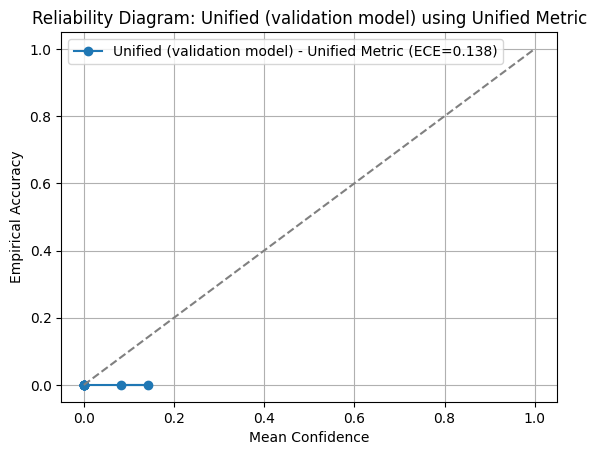

Unified metric ECE: 0.138


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(unified_confidence_val, y_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')


In [ ]:
X1_train1, y1_train1 = get_features_labels(qwen_df)
X1_train2, y1_train2 = get_features_labels(llama_df)
X1_train = np.concatenate([X1_train1, X1_train2])
y1_train = np.concatenate([y1_train1, y1_train2])

X1_val, y1_val = get_features_labels(phi2_df)

In [ ]:
clf1 = LogisticRegression()
clf1.fit(X1_train, y1_train)
unified_confidence_val1 = clf1.predict_proba(X1_val)[:, 1]

In [ ]:
unified_confidence_val1

array([0.04383697, 0.03903078, 0.0437561 , 0.02795328, 0.03736188,
       0.04432181, 0.03298809, 0.03576156, 0.03680055, 0.0399667 ,
       0.03407839, 0.04526167, 0.05330633, 0.0609488 , 0.04311172,
       0.0397774 , 0.04841409, 0.05746783, 0.04421767, 0.0467785 ,
       0.06571123, 0.04196083, 0.030138  , 0.04397336, 0.03457584,
       0.0578083 , 0.03544696, 0.03335161, 0.04362826, 0.03680717,
       0.03793598, 0.03993613, 0.03329075, 0.0357334 , 0.03132333,
       0.04468829, 0.03738143, 0.05657089, 0.03454132, 0.04507668,
       0.0430388 , 0.04662922, 0.04718675, 0.03967279, 0.05369927,
       0.03918721, 0.04336816, 0.03773757, 0.04771641, 0.02942948])

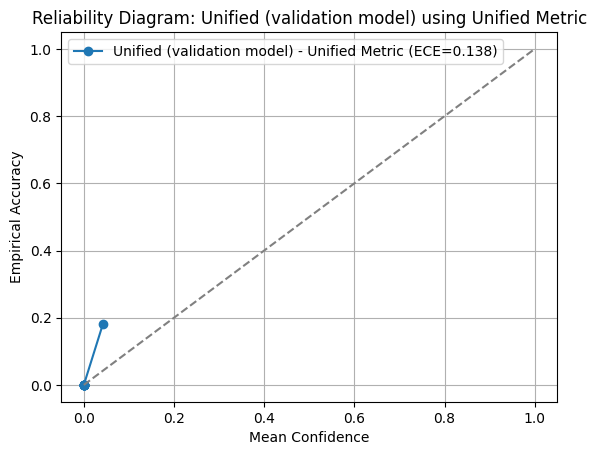

Unified metric ECE: 0.138


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(unified_confidence_val1, y1_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
unified_confidence_val_xb_1 = xgb_model.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:07:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
unified_confidence_val_xb_1

array([0.337204  , 0.00330274, 0.03093077, 0.07026655, 0.03553546,
       0.00330274, 0.32106942, 0.7213996 , 0.01360989, 0.05336355,
       0.00432397, 0.00330274, 0.00330274, 0.00517266, 0.00432397,
       0.16754013, 0.0258908 , 0.0242521 , 0.03093077, 0.0582761 ,
       0.05336355, 0.00517266, 0.2702241 , 0.06967825, 0.16746284,
       0.00432397, 0.0242521 , 0.01628916, 0.03093077, 0.0121797 ,
       0.01475285, 0.00330274, 0.32106942, 0.05336355, 0.04261852,
       0.01360989, 0.05573523, 0.01713256, 0.00330274, 0.337204  ,
       0.12710367, 0.05336355, 0.00330274, 0.27923778, 0.00432397,
       0.00432397, 0.0285226 , 0.00517266, 0.05031322, 0.02694068],
      dtype=float32)

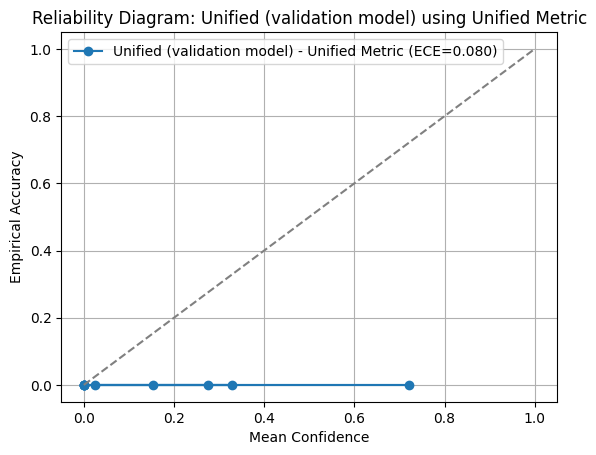

Unified metric ECE: 0.080


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(unified_confidence_val_xb_1, y_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')

In [ ]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X1_train, y1_train)
unified_confidence_val_xb_1 = xgb_model.predict_proba(X1_val)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:25:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
unified_confidence_val_xb_1

array([0.09007263, 0.03205917, 0.09007263, 0.00764838, 0.01684536,
       0.1039996 , 0.00344118, 0.03205917, 0.00764838, 0.00793424,
       0.03205917, 0.0236943 , 0.05089326, 0.01075628, 0.06569648,
       0.00344118, 0.06229573, 0.1891148 , 0.0236943 , 0.0236943 ,
       0.1891148 , 0.00761795, 0.00764838, 0.01462202, 0.0236943 ,
       0.1891148 , 0.00764838, 0.00578924, 0.01527847, 0.00344118,
       0.00344118, 0.01421159, 0.00764838, 0.02324415, 0.00764838,
       0.01462202, 0.02324415, 0.1891148 , 0.00764838, 0.01462202,
       0.01522465, 0.04025855, 0.03868894, 0.0236943 , 0.05089326,
       0.09007263, 0.01462202, 0.03205917, 0.01800556, 0.00764838],
      dtype=float32)

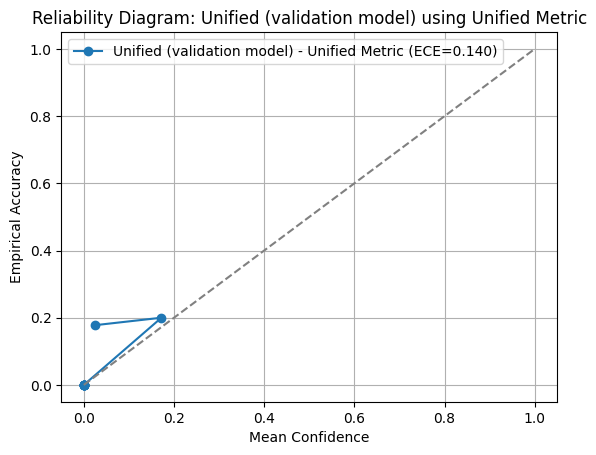

Unified metric ECE: 0.140


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(unified_confidence_val_xb_1, y1_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')

In [ ]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
svc = SVC(probability=True, kernel='linear', random_state=42)
svc.fit(X_train, y_train)
svm_confidence_val = svc.predict_proba(X_val)[:, 1]


In [ ]:
svm_confidence_val

array([0.12434522, 0.12712637, 0.1209411 , 0.12553693, 0.12781391,
       0.12586908, 0.12380114, 0.12921635, 0.12722168, 0.11700649,
       0.13201382, 0.1258499 , 0.12643591, 0.13667392, 0.13058609,
       0.12990647, 0.12114678, 0.12256986, 0.12055315, 0.1233378 ,
       0.11762112, 0.13637724, 0.11665656, 0.12872989, 0.13457062,
       0.13231788, 0.12125785, 0.13306303, 0.12083412, 0.13279409,
       0.12593607, 0.12699226, 0.12410877, 0.1169672 , 0.11615283,
       0.12519265, 0.12261975, 0.1314863 , 0.12570456, 0.12448407,
       0.1313294 , 0.11722271, 0.12629731, 0.12876982, 0.13217775,
       0.13271033, 0.12235658, 0.15352516, 0.12252684, 0.12225361])

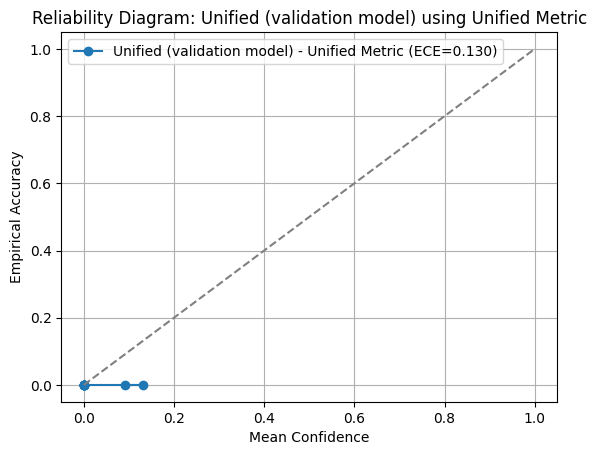

Unified metric ECE: 0.130


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(svm_confidence_val, y_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')

In [ ]:
svc = SVC(probability=True, kernel='linear', random_state=42)
svc.fit(X1_train, y1_train)
svm_confidence_val = svc.predict_proba(X1_val)[:, 1]

In [ ]:
svm_confidence_val

array([0.02679631, 0.05009368, 0.02692828, 0.0508769 , 0.04533236,
       0.02888993, 0.03307197, 0.0601044 , 0.04252721, 0.03798656,
       0.06775095, 0.04793459, 0.0310384 , 0.03665916, 0.03109402,
       0.03466582, 0.02835271, 0.02535369, 0.05096182, 0.04394673,
       0.02990502, 0.03340494, 0.05229017, 0.03661881, 0.09036069,
       0.0249523 , 0.04082586, 0.03798268, 0.03225669, 0.03698891,
       0.03416394, 0.02983046, 0.05518467, 0.0268005 , 0.04302731,
       0.03508747, 0.02706018, 0.02645326, 0.05016171, 0.03429138,
       0.03875841, 0.03134   , 0.03036335, 0.06446864, 0.03043292,
       0.02630054, 0.03798575, 0.05468113, 0.04169913, 0.05559227])

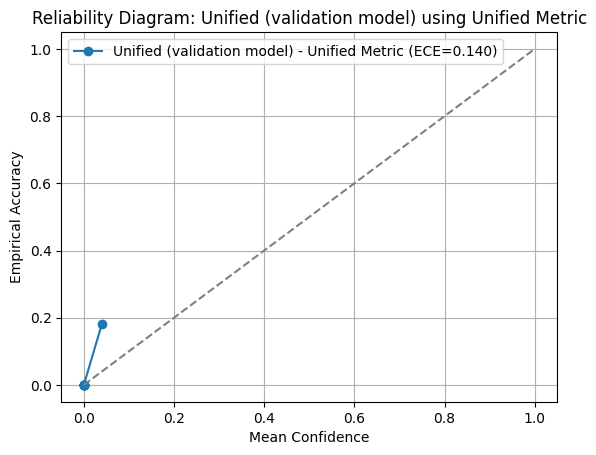

Unified metric ECE: 0.140


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(svm_confidence_val, y1_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')

In [ ]:
svc = SVC(probability=True, kernel='rbf', random_state=42)
svc.fit(X_train, y_train)
svm_confidence_val = svc.predict_proba(X_val)[:, 1]

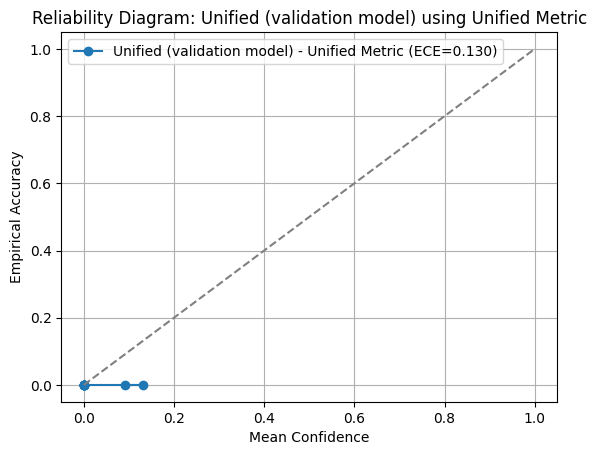

Unified metric ECE: 0.130


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(svm_confidence_val, y_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')

Advance methods.

In [ ]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(unified_confidence_val1, y1_val)
calibrated_conf_val = iso_reg.transform(unified_confidence_val)


In [ ]:
calibrated_conf_val

array([0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429])

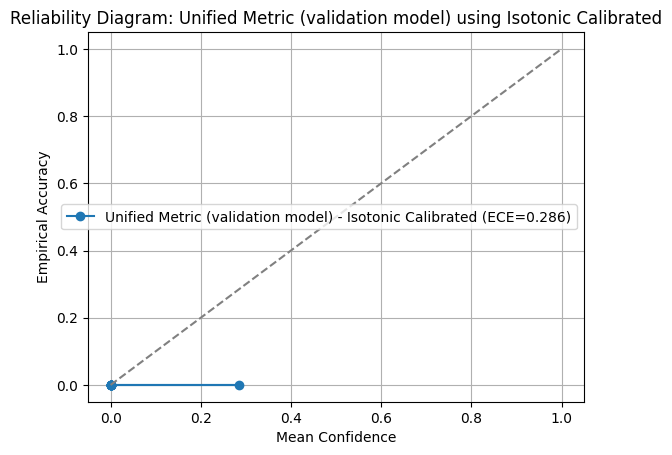

Isotonic calibrated metric ECE: 0.286


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(calibrated_conf_val, y_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified Metric (validation model)', 'Isotonic Calibrated', ece)
print(f'Isotonic calibrated metric ECE: {ece:.3f}')

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=4, verbose=0, random_seed=42)
cb.fit(X_train, y_train)
cb_confidence_val = cb.predict_proba(X_val)[:, 1]


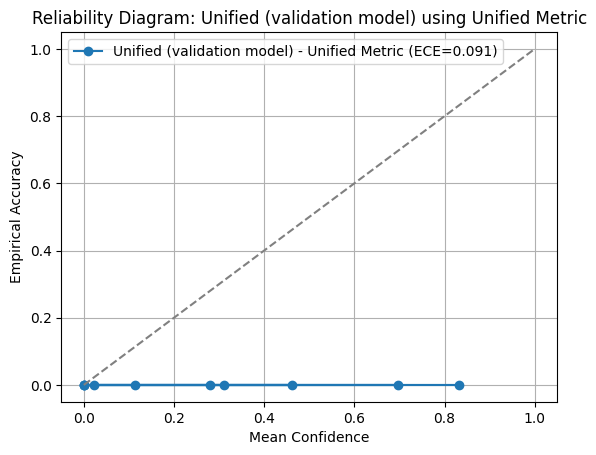

Unified metric ECE: 0.091


In [ ]:
conf_bin, acc_bin, ece = compute_reliability_diagram(cb_confidence_val, y_val)
plot_reliability_curve(conf_bin, acc_bin, 'Unified (validation model)', 'Unified Metric', ece)
print(f'Unified metric ECE: {ece:.3f}')